# Simulated Annealing

## Template SA

```python
import random
import math

def objective_function(solution):
    # Your objective function implementation here
    # Evaluate the quality of the solution and return a fitness score
    pass

def generate_neighbor(solution):
    # Your neighbor generation function here
    # Generate a neighboring solution based on the current solution
    pass

def acceptance_probability(current_fitness, new_fitness, temperature):
    if new_fitness > current_fitness:
        return 1.0
    else:
        return math.exp((new_fitness - current_fitness) / temperature)

def simulated_annealing(initial_solution, initial_temperature, cooling_rate):

    current_solution = initial_solution
    current_fitness = objective_function(current_solution)

    best_solution = current_solution
    best_fitness = current_fitness

    temperature = initial_temperature

    while temperature > 0.1:  # Adjust the termination condition as needed
        
        new_solution = generate_neighbor(current_solution)
        new_fitness = objective_function(new_solution)

        acceptance_prob = acceptance_probability(current_fitness, new_fitness, temperature)
        
        if random.random() < acceptance_prob:
            current_solution = new_solution
            current_fitness = new_fitness

        if new_fitness > best_fitness:
            best_solution = new_solution
            best_fitness = new_fitness

        temperature *= cooling_rate

    return best_solution, best_fitness

# Example usage
initial_solution = ...  # Initialize your initial solution
initial_temperature = ...  # Set the initial temperature
cooling_rate = ...  # Set the cooling rate

best_solution, best_fitness = simulated_annealing(initial_solution, initial_temperature, cooling_rate)

print("Best solution:", best_solution)
print("Best fitness:", best_fitness)
```

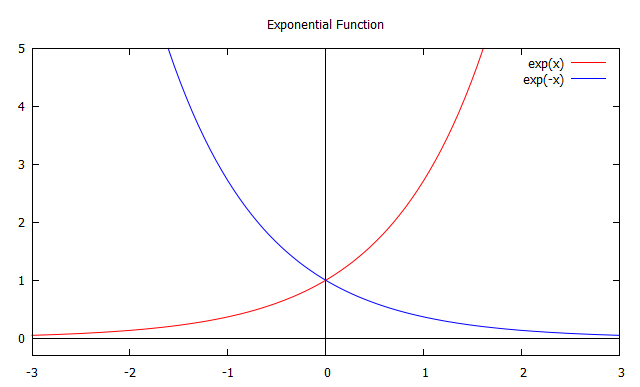

## SA aplicado ao TSP - animação

In [ ]:
#%matplotlib inline

### Importações

In [ ]:
import numpy as np
import math
import random

from IPython.display import clear_output
import matplotlib.pyplot as plt

### Funções para plotar os gráficos

In [ ]:
def plot_path(cities_xy, cities_path, ax):

    # Reeordena as cidades pela ordem do caminho
    cities = cities_xy[cities_path]

    # Repete a primeira cidade para fechar o ciclo
    x = cities[:,0]
    y = cities[:,1]

    # Personalização do gráfico
    ax.set_xlabel('X (Longitude)')
    ax.set_ylabel('Y (Latitude)')
    ax.set_title('Caminho')

    # Plotagem das coordenadas interligadas com pontos vermelhos e linhas azuis
    ax.plot(x, y, color='blue', linestyle='-', linewidth=2)
    ax.plot(x, y, color='red', marker='o', markersize=8, linestyle='')
    ax.plot(x[[-1,0]], y[[-1,0]], color='orange', linestyle='-', linewidth=2)

def plot_distances(iteration_list, distance_list, best_distances, ax):

    x  = iteration_list
    y1 = distance_list
    y2 = best_distances

    # Personalização do gráfico
    ax.set_xlabel('Iterações')
    ax.set_ylabel('Distâncias (custos)')
    ax.set_title('Comprimento Total do caminho')

    ax.plot(x,y1, label='Atual')
    ax.plot(x,y2, label='Melhor')
    ax.legend()

def plot_acceptance_prob(iteration_list, accept_p_list, ax):

    x = iteration_list
    y = accept_p_list

    # Personalização do gráfico
    ax.set_xlabel('Iterações')
    ax.set_ylabel('Probabilidade')
    ax.set_title('Probabilidade de Aceitação')

    ax.set_ylim([0, 1.05])

    # Criar uma nova lista de cores com base nos valores de y
    xc, yc, colors = zip(*[(xi, yi, 'b') if yi==1.0 else (xi, yi, 'r') \
                           for xi, yi in enumerate(y)])

    ax.scatter(xc, yc, c=colors, s=2)

def plot_temperature(iteration_list, temperat_list, ax):

    x = iteration_list
    y = temperat_list

    # Personalização do gráfico
    ax.set_xlabel('Iterações')
    ax.set_ylabel('Temperatura')
    ax.set_title('Decaimento da Temperatura')

    ax.set_ylim([0, 1000])

    ax.plot(x,y)

#----------------------------------------------------------------

def plot_axes_figure(cities_xy, cities_path, iteration_list,
                     distance_list, best_distances,
                     accept_p_list, temperat_list):

    x = iteration_list
    y1 = distance_list
    y2 = best_distances
    y3 = accept_p_list
    y4 = temperat_list

    clear_output(wait=True)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,8))

    plot_path(cities_xy, cities_path, ax1)
    plot_distances      (x, y1, y2, ax2)
    plot_acceptance_prob(x, y3, ax3)
    plot_temperature    (x, y4, ax4)

    # Ajusta o espaçamento entre os subgráficos
    fig.tight_layout()

    plt.pause(0.001)

#-----------------------------------------------------
#-----------------------------------------------------


### Implementação do SA aplicado ao TSP

In [ ]:
def calculate_distance(city_a, city_b):
    dx = city_a[0] - city_b[0]
    dy = city_a[1] - city_b[1]
    # calculo da distancia euclidiana
    dist = math.sqrt(dx**2 + dy**2)
    return dist

def total_distance(route, distance_matrix):
    total = 0
    for i in range(len(route) - 1):
        city_a = route[i]
        city_b = route[i + 1]
        total += distance_matrix[city_a, city_b]

    total += distance_matrix[route[-1], route[0]]

    return total

def generate_neighbor(route):
    new_route = route.copy()
    n = len(new_route)
    index_a = random.randint(0, n-1)
    index_b = random.randint(0, n-1)
    new_route[index_a], new_route[index_b] = new_route[index_b], new_route[index_a]
    return new_route

def acceptance_probability(current_distance, new_distance, temperature):
    if new_distance < current_distance: # melhor == menor (<)
        return 1.0
    else:
        delta = (current_distance - new_distance)
        return math.exp(delta / temperature)

def generate_distance_matrix(cities):
    num_cities = len(cities)
    distance_matrix = np.zeros((num_cities, num_cities))
    for i in range(num_cities):
        for j in range(num_cities):
            distance_matrix[i, j] = calculate_distance(cities[i], cities[j])

    return distance_matrix, num_cities

def simulated_annealing(cities, initial_temperature, cooling_rate, iterations, nrep=50):

    num_cities = len(cities)

    distance_matrix, num_cities = generate_distance_matrix(cities)

    current_route = np.arange(num_cities)
    best_route = current_route.copy()

    current_distance = total_distance(current_route, distance_matrix)
    best_distance = current_distance

    temperature = initial_temperature

    #-----------------------------------------------
    iteration_list = []
    best_distances = []
    distance_list  = []
    accept_p_list  = []
    temperat_list  = []
    #-----------------------------------------------

    for iteration in range(iterations):

        # numero de vizinhos a serem gerados e testados para cada iteração
        for _ in range(nrep):

            new_route = generate_neighbor(current_route)
            new_distance = total_distance(new_route, distance_matrix)

            acceptance_prob = acceptance_probability(current_distance, new_distance, temperature)

            #print(acceptance_prob)

            if random.random() < acceptance_prob:
                current_route = new_route
                current_distance = new_distance

        temperature *= cooling_rate


        #-----------------------------------------------
        if new_distance < best_distance:
            best_route = new_route
            best_distance = new_distance

        iteration_list += [iteration]
        best_distances += [best_distance]
        distance_list  += [current_distance]
        accept_p_list  += [acceptance_prob]
        temperat_list  += [temperature]

        if iteration % 50 == 0:
            plot_axes_figure(cities, current_route, iteration_list,
                            distance_list, best_distances,
                            accept_p_list, temperat_list)
        #-----------------------------------------------

    # plt.show()

    return best_route, best_distance


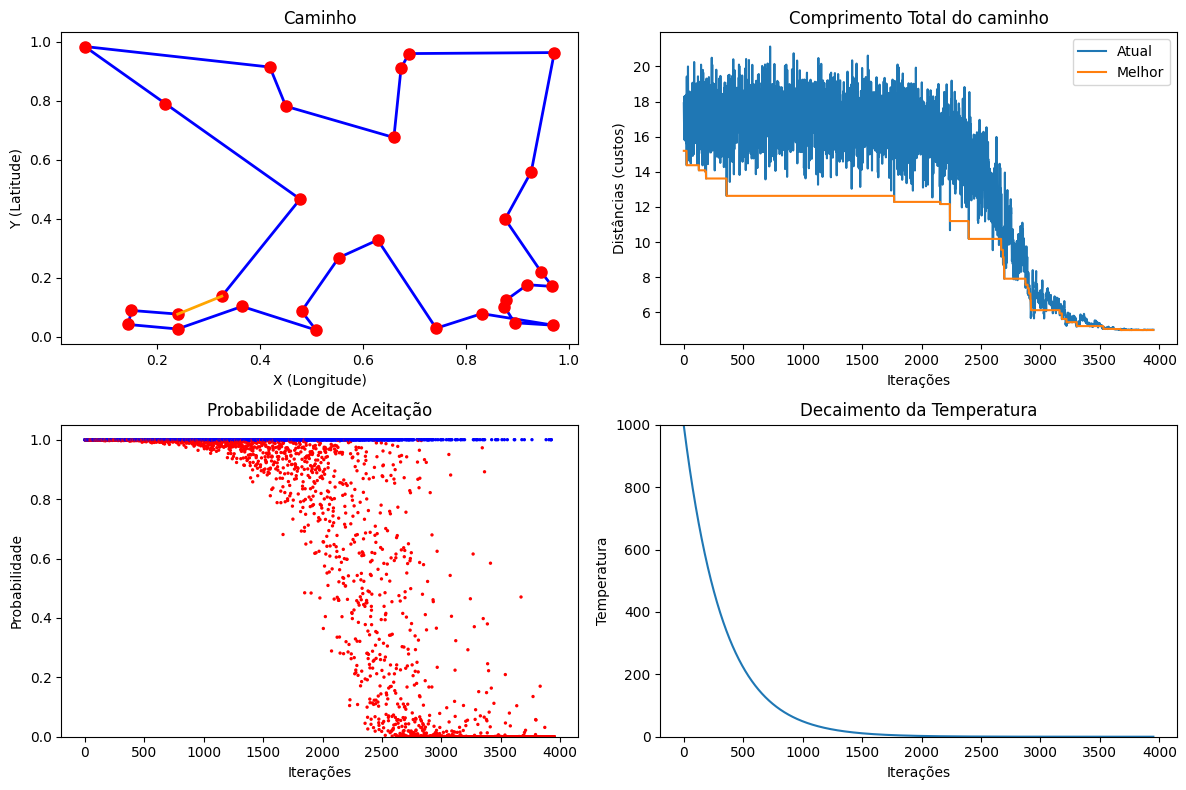

Best route: [27 20 10  9 18 13  6  4  3 15  7 23 22 25 26 24 14  8  1 17 11 29 16  2
 19 12  0  5 21 28]
Best distance: 4.990459964647315


In [ ]:
def main():
    # Exemplo de uso
    num_cities = 30
    cities = np.random.rand(num_cities, 2)

    initial_temperature = 1000.0    # 100 200 500 1000 2000
    cooling_rate = 0.997            # 0.99, 0.995, 0.997 0.999
    iterations = 4000

    best_route, best_distance = simulated_annealing(cities, initial_temperature, cooling_rate, iterations)

    print("Best route:", best_route)
    print("Best distance:", best_distance)


if __name__ == '__main__':
    main()


In [ ]:
# Faça o código sem instrumentação
# ...


In [ ]:
# Apenas para você averiguar como funcionam
# os calculos de probabilidade
# p = 0.25
# total = 100000
# n_trues = 0

# for i in range(total):
#     if random.random() < p:
#         n_trues += 1

# print (n_trues/total)

0.25083


---
---
---

## Exercícios de fixação do conteúdo

O programa em questão é uma implementação do algoritmo Simulated Annealing para resolver o problema do Caixeiro Viajante (Traveling Salesman Problem). Ele gera um conjunto de cidades aleatórias no plano, calcula a distância entre elas e encontra o melhor caminho possível que percorre todas as cidades uma única vez, minimizando a distância total percorrida.

Os principais componentes do programa são as funções `simulated_annealing`, que implementa o algoritmo Simulated Annealing, e as funções de plotagem para visualização dos resultados.

1) Exercícios conceituais

    1. Explique brevemente o algoritmo Simulated Annealing e seu objetivo neste programa.
    2. Identifique e explique a função que calcula a distância entre duas cidades (L1-norm ou L2-norm?).
    3. Identifique e explique a função que calcula a distância total percorrida em um determinado caminho.
    4. Explique a função que gera um caminho vizinho ao caminho atual, trocando a posição de duas cidades aleatórias.
    5. Identifique e explique a função que calcula a probabilidade de aceitação de um caminho pior em relação ao atual, com base na temperatura.
    6. Identifique e explique a função principal `simulated_annealing`, incluindo seus parâmetros e o fluxo do algoritmo.
    7. Identifique a função `main` e explique o exemplo de uso fornecido.

2) Exercícios de implementação

    1. O que é a matriz de distâncias e qual é o seu propósito no algoritmo?

    2. Explique o propósito das listas `iteration_list`, `best_distances`, `distance_list`, `accept_p_list` e `temperat_list` e como elas são usadas no programa.

    3. Por que é importante realizar o resfriamento gradual da temperatura (`temperature`) ao longo das iterações? Como o parâmetro `cooling_rate` afeta o processo de resfriamento?

    4. Identifique e explique a função `plot_axes_figure`. Como ela é chamada e qual é a sua finalidade?

    5. Como o programa garante que todas as cidades são percorridas uma única vez no caminho resultante?

    6. Quais são as informações exibidas nos gráficos gerados pelas funções de plotagem? Como esses gráficos ajudam na visualização e análise do desempenho do algoritmo?

    7. Em que situação o programa exibe os gráficos de atualização? Qual é a frequência dessa exibição e qual é o propósito de mostrar esses gráficos durante a execução do algoritmo?


3) Os parâmetros ```initial_temperature```, ```cooling_rate``` e ```iterations``` desempenham papéis importantes no desempenho do algoritmo *Simulated Annealing*. Explique como a variação desses parâmetros pode afetar a qualidade da solução encontrada e a eficiência do algoritmo. Discuta possíveis estratégias para ajustar esses parâmetros de forma a obter melhores resultados na resolução do problema do Caixeiro Viajante.



---



## Exercício para entregar próxima aula

---



1. Adaptar o código do SA para resolver o problema do link abaixo:

    **Western Sahara**

    29 cidades
    The optimal tour has length 27.603

    Foto dos Pontos: http://www.math.uwaterloo.ca/tsp/world/wipoints.html

    Foto da Solução: http://www.math.uwaterloo.ca/tsp/world/witour.html

    Download dos Dados: http://www.math.uwaterloo.ca/tsp/world/wi29.tsp


2) Implementar nesse mesmo notebook o *HILL-CLIMBING com Restart* E COMPARAR COM O SA

In [ ]:
import pandas as pd

In [ ]:
# url_coordenadas_cidade = 'https://www.math.uwaterloo.ca/tsp/world/wi29.tsp'
url_coordenadas_cidade = 'http://www.math.uwaterloo.ca/tsp/world/qa194.tsp'

df_coordenadas = pd.read_table(
                    url_coordenadas_cidade,
                    skiprows=7,           # ignora as 7 primeiras linhas com informações
                    names=['X', 'Y'],     # nomes das colunas
                    sep=' ',              # separador das colunas
                    index_col=0,          # usar col=0 como index (nome das cidades)
                    skipfooter=1,         # ignora a última linha (EOF)
                    engine='python'       # para o parser usar skipfooter sem warning
              )

In [ ]:
# df_coordenadas

In [ ]:
    # Exemplo de uso
    cities = np.array(df_coordenadas)

    initial_temperature = 1000.0    # 100 200 500 1000 2000
    cooling_rate = 0.999            # 0.99, 0.995, 0.997 0.999
    iterations = 12000

    best_route, best_distance = simulated_annealing(cities, initial_temperature, cooling_rate, iterations)

    print("Best route:", best_route)
    print("Best distance:", best_distance)

NameError: name 'np' is not defined


    Western Sahara
    29 cidades
    The optimal tour has length 27.603
    Foto dos Pontos: http://www.math.uwaterloo.ca/tsp/world/wipoints.html
    Foto da Solução: http://www.math.uwaterloo.ca/tsp/world/witour.html
    Download dos Dados: http://www.math.uwaterloo.ca/tsp/world/wi29.tsp

    Djibouti dataset
    38 cidades
    The optimal tour has length 6.656
    Foto dos Pontos: http://www.math.uwaterloo.ca/tsp/world/djpoints.html
    Foto da Solução: http://www.math.uwaterloo.ca/tsp/world/djtour.html
    Download dos Dados: http://www.math.uwaterloo.ca/tsp/world/dj38.tsp

    Qatar
    194 cidades
    The optimal tour has length 9.352
    Foto dos Pontos: http://www.math.uwaterloo.ca/tsp/world/qapoints.html
    Foto da Solução: http://www.math.uwaterloo.ca/tsp/world/qatour.html
    Download dos Dados: http://www.math.uwaterloo.ca/tsp/world/qa194.tsp

    Uruguay
    734 cidades
    The optimal tour has length 79.114
    Foto dos Pontos: http://www.math.uwaterloo.ca/tsp/world/uypoints.html
    Foto da Solução: http://www.math.uwaterloo.ca/tsp/world/uytour.html
    Download dos Dados: http://www.math.uwaterloo.ca/tsp/world/uy734.tsp